In [9]:
import numpy as np  
import scipy
import matplotlib.pyplot as plt 

def fDiffMat(order, dx): 
    s = order 
    mat = np.zeros((s, s))
    for k in range(1, s+1):
        for j in range(1, s+1): 
            mat[j-1, k-1] = (j * dx)**k / np.math.factorial(k)

    return mat 

def bDiffMat(order, dx): 
    s = order 
    mat = np.zeros((s, s))
    for k in range(1, s+1):
        for j in range(1, s+1): 
            mat[j-1, k-1] = (-j * dx)**k / np.math.factorial(k)

    return mat 

def fDiffVec(order, f): 
    diff = np.zeros(order)
    for j in range(1, order + 1):
        diff[j-1] = f[j] - f[0]
    return diff 

def bDiffVec(order, f): 
    diff = np.zeros(order)
    for j in range(1, order + 1):
        diff[j-1] = (f[-1-j] - f[-1])
    return diff 

def cosineDiffVec(order, f, Dl, Dr):
    b = np.zeros(2*order) 
    b[0] = f[ 0]
    b[1] = f[-1]
    for i in range(1, order): 
        b[i*2    ] = Dl[i]/(np.pi)**(2*i) 

    for i in range(1, order): 
        b[i*2 + 1] = Dr[i]/(np.pi)**(2*i) 

    return b 

def cosineDiffMat(order): 
    A = np.zeros((order*2, order*2))
    for i in range(order): 
        derivative  = 2 * i 
        for j in range(1, 2*order+1):
            #Every derivative gives a factor of j -- j**derivative
            #Every second derivative gives a minus sign -- (-1)**i 
            #Cosine evaluated at pi gives negative sign depending on wavelength -- (-1)**j
            A[2*i  , j-1] = j**derivative * (-1)**i
            A[2*i+1, j-1] = j**derivative * (-1)**i * (-1)**j 

    return A


def iterativeRefinement(A, b, tolerance = 1e-9): 
    C = np.linalg.solve(A, b) 
    residual      = b - A @ C
    residualError = np.sum(np.abs(residual)) 

    iteration = 0
    while residualError > tolerance:
        correction = np.linalg.solve(A, residual) 
        C += correction
        residual = b - A @ C
        residualError = np.sum(np.abs(residual)) 
        iteration += 1
        if iteration > 10:
            break
        
    return C 

def reconstruct(C, x, derivative_order = 0):
    f = np.zeros(x.shape) 
    L = x[-1] - x[0]
    xeval = shiftx(x) 
    for k in range(1, len(C) + 1):
        f += C[k-1] * np.real((1j * k * np.pi * L) ** derivative_order * np.exp(1j * k * np.pi * xeval))

    return f

def shiftx(x):
    return (x - x[0])/(x[-1] - x[0])

def getShiftFunction(f, order, x): 
    xeval = shiftx(x) 
    dx = xeval[1] - xeval[0]
    A = fDiffMat (order, dx) 
    b = fDiffVec (order, f)
    Dl = iterativeRefinement(A, b)

    A = bDiffMat (order, dx) 
    b = bDiffVec (order,  f)

    Dr = iterativeRefinement(A, b)

    A = cosineDiffMat(int(order/2)) 
    b = cosineDiffVec(int(order/2), f, Dl, Dr)
    C = iterativeRefinement(A, b)


    shift = reconstruct(C, xeval)
    return shift, C, xeval

def antisymmetricExtension(f, debug=False):
    fext = np.concatenate([f, -np.flip(f)[1:-1]])
    if debug: 
        plt.title("First derivative")
        plt.plot(np.roll(fext, -1) - fext)
        plt.show()
        plt.title("Second derivative")
        plt.plot(np.roll(fext, -1) - 2 * fext + np.roll(fext, 1))
        plt.show()
    return fext 


def getk(p, dx): 
    N = len(p) 
    L = len(p) * dx
    k = 2 * np.pi/ L * np.arange(-N/2, N/2)
    return np.fft.ifftshift(k) 

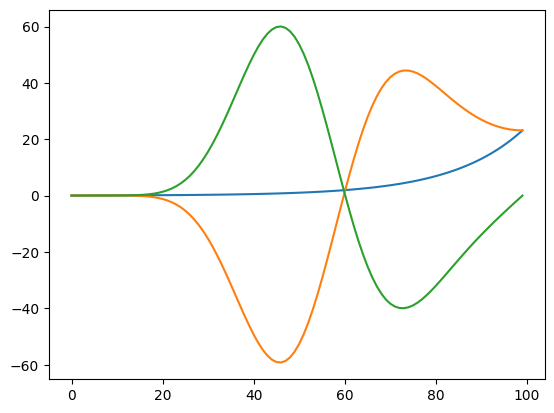

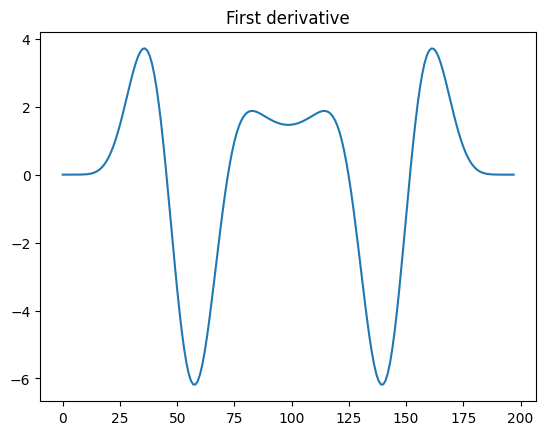

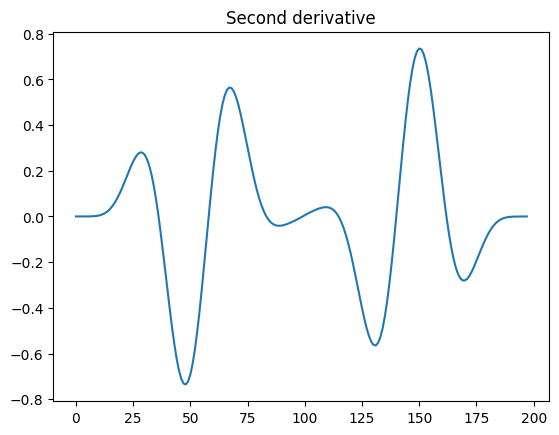

In [10]:
x = np.linspace(-np.pi, np.pi, 100) 
f = np.exp(x) 
shift, C, xeval = getShiftFunction(f, 9, x) 
plt.plot(f) 
plt.plot(shift)
plt.plot(f - shift)
plt.show()
fext = antisymmetricExtension(f - shift, debug=True)

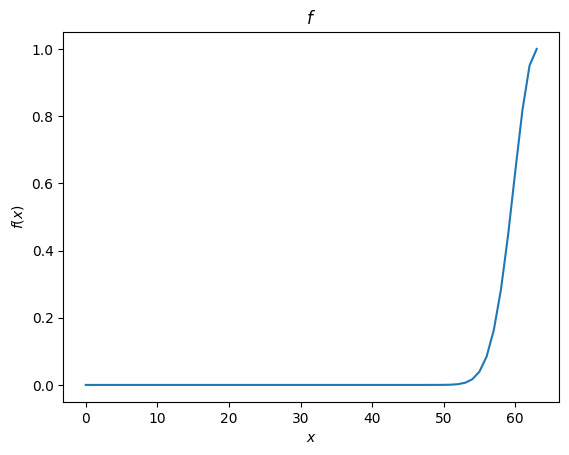

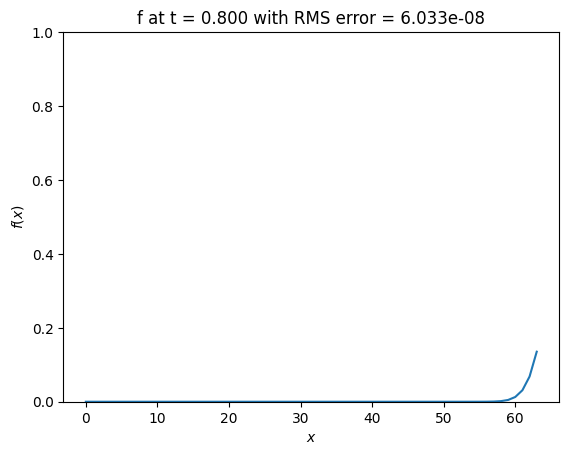

In [11]:
import spectral_derivative as sd
import numpy as np 
import matplotlib.pyplot as plt

L                 = 1
N                 = 64
x                 = np.linspace(0, L, N)
dx                = x[1] - x[0]
dt                = 1e-4
v                 = 1
t                 = 0.7
tend              = 1.0
r                 = (v * dt)**2
ghostBoundary     = 8
smoothingOrder    = 9

def func(x, v, t):
    return np.exp(-(x-0.3 - t * v)**2/0.005)

f  = func(x, v, t    )
fm = func(x, v, t - dt)

plt.title(r"$f$")
plt.plot(f)
plt.xlabel(r"$x$")
plt.ylabel(r"$f(x)$")
plt.show()

for i in range(1000):
    #Fill ghost zone of length ghost boundary with boundary conditions
    for i in range(ghostBoundary + 1): 
        f[     i] = func(     i * dx, v, t)
        f[-1 - i] = func( L - i * dx, v, t)

    #Create shift function that such that f - B fulfills either Dirichlet, Neumann or periodic boundary conditions depending on mode
    shift, C, xeval = getShiftFunction(f, smoothingOrder, x) 

    #Subtract linear shift function to enforce Dirichlet BC when computing second derivative

    if 1:
        homf            = f - shift
        extf            = antisymmetricExtension(homf)
        k               = getk(extf, dx) 
        ddf             = (scipy.fft.ifft((-k**2) * scipy.fft.fft(extf))[:N]).real + reconstruct(C, x, 2)

    else: 
        k               = getk(f, dx) 
        ddf             = (scipy.fft.ifft((-k**2) * scipy.fft.fft(f))).real
        
    fp   = 2 * f  - fm  + r * ddf
    fm   = f 
    f    = fp
    t   += dt 

plt.title(f"f at t = {t:3.3f} with RMS error = {np.mean(np.abs(f - func(x, v, t))):3.3e}")
plt.plot(f)
plt.ylim([0, 1])
plt.xlabel(r"$x$")
plt.ylabel(r"$f(x)$")
plt.show()

In [ ]:
x = np.linspace(0, 1, 10)
dx = x[1] - x[0]
dx * 10 